## Require packages

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from __future__ import division
import gpxpy.geo
from datetime import datetime
from collections import defaultdict

In [2]:
credit_card= pd.read_csv('cc_info.csv')

In [3]:
print credit_card.head()

        credit_card      city state  zipcode  credit_card_limit
0  1280981422329509    Dallas    PA    18612               6000
1  9737219864179988   Houston    PA    15342              16000
2  4749889059323202    Auburn    MA     1501              14000
3  9591503562024072   Orlando    WV    26412              18000
4  2095640259001271  New York    NY    10001              20000


In [4]:
zipcode= pd.read_csv('US.txt',sep='\t',header=None)
zipcode.columns=['code','zipcode','name','name1','code1','name2','code2','name3','code3','latitude','longitude','accu']

In [5]:
credit_card_union = pd.merge(credit_card,zipcode,on='zipcode')

In [6]:
credit_card_union=credit_card_union.drop(['code','name','name1','code1','name2','code2','name3','code3','accu'],axis=1)

In [7]:
print credit_card_union.head()

        credit_card    city state  zipcode  credit_card_limit  latitude  \
0  1280981422329509  Dallas    PA    18612               6000   41.3494   
1  9722420012449776  Dallas    PA    18612               6000   41.3494   
2  4290726060535834  Dallas    PA    18612              10000   41.3494   
3  3342907490282079  Dallas    PA    18612               5000   41.3494   
4  4833760023644511  Dallas    PA    18612              30000   41.3494   

   longitude  
0   -75.9834  
1   -75.9834  
2   -75.9834  
3   -75.9834  
4   -75.9834  


In [8]:
trans= pd.read_csv('transactions.csv')

In [9]:
print trans.head()

        credit_card                 date  transaction_dollar_amount  \
0  1003715054175576  2015-09-11 00:32:40                      43.78   
1  1003715054175576  2015-10-24 22:23:08                     103.15   
2  1003715054175576  2015-10-26 18:19:36                      48.55   
3  1003715054175576  2015-10-22 19:41:10                     136.18   
4  1003715054175576  2015-10-26 20:08:22                      71.82   

        Long        Lat  
0 -80.174132  40.267370  
1 -80.194240  40.180114  
2 -80.211033  40.313004  
3 -80.174138  40.290895  
4 -80.238720  40.166719  


In [10]:
def weekDay(date):
    date=datetime.strptime(date,"%Y-%m-%d")
    year=date.year
    month=date.month
    day= date.day
    offset = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
    week   = ['Sunday', 
              'Monday', 
              'Tuesday', 
              'Wednesday', 
              'Thursday',  
              'Friday', 
              'Saturday']
    afterFeb = 1
    if month > 2: afterFeb = 0
    aux = year - 1700 - afterFeb
    # dayOfWeek for 1700/1/1 = 5, Friday
    dayOfWeek  = 5
    # partial sum of days betweem current date and 1700/1/1
    dayOfWeek += (aux + afterFeb) * 365                  
    # leap year correction    
    dayOfWeek += aux / 4 - aux / 100 + (aux + 100) / 400     
    # sum monthly and day offsets
    dayOfWeek += offset[month - 1] + (day - 1)               
    dayOfWeek %= 7
    return int(dayOfWeek)

In [11]:
def distance(data):
    # What you were looking for
    lat1=data['latitude']
    lon1=data['longitude']
    
    lon2=data['Long']
    lat2=data['Lat']
    dist = gpxpy.geo.haversine_distance(lat1, lon1, lat2, lon2)
    return dist/1000

In [12]:
def weekend(data):
    if data==0 or data==6:
        return 1
    else: 
        return 0

In [13]:
def check(data):
    amount = data[0]
    value = data[1]
    if amount > value :
        return 1
    else:
        return 0 

In [14]:
def possible_fraud(data):
    amount_check=data[0]
    distance_check = data[1]
    if amount_check ==1 or distance_check ==1:
        return 1
    else:
        return 0

In [15]:
def limitedexceed(data):
    limit = data['credit_card_limit']
    trans_amount=data['transaction_dollar_amount']
    if trans_amount>=limit:
        return 1 
    else:
        return 0
    

In [16]:
def above_spend(trans,date):
    user_info = {}
    User_list = []
    Month=datetime.strptime(date,"%Y-%m-%d").month
    
    trans['Date']=trans['date'].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d"))
    trans['Month']=trans['date'].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").month)
    trans=trans[(trans['Date']<=date)&(trans['Month']==Month)]

    trans_group= trans.groupby(['Month','credit_card'])
    trans_pivot = pd.DataFrame(trans_group['transaction_dollar_amount'].sum()).reset_index()
    trans_union = pd.merge(trans_pivot,credit_card,on='credit_card')
    trans_union['Limit1']=trans_union[['credit_card_limit','transaction_dollar_amount']].apply(limitedexceed,axis=1)
    
    for i in range(0, len(trans_union)):
        #print i 
        if trans_union['Limit1'][i]==1:
            credit_card1 = trans_union['credit_card'][i]
            city=trans_union['city'][i]
            state=trans_union['state'][i]
            zipcode=trans_union['zipcode'][i]
            user_info={'Credit_Card':credit_card1,
                       'City':city,
                       'State':state,
                       'Zipcode':zipcode
                               
            }
            
            User_list.append(user_info)
            
        else:
            continue
        
        
    return User_list

In [17]:
def never_spend(trans,calendar_month):
    user_info = {}
    User_list = []
    trans['Month']=trans['date'].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").month)
    trans_group= trans.groupby(['Month','credit_card'])
    trans_pivot = pd.DataFrame(trans_group['transaction_dollar_amount'].sum()).reset_index()
    trans_union = pd.merge(trans_pivot,credit_card,on='credit_card')
    trans_union['Limit1']=trans_union[['credit_card_limit','transaction_dollar_amount']].apply(limitedexceed,axis=1)
    
    
    for i in range(0, len(trans_union)):
        #print i 
        if (trans_union['Month'][i]==calendar_month )and (trans_union['Limit1'][i]==0):
            credit_card1 = trans_union['credit_card'][i]
            city=trans_union['city'][i]
            state=trans_union['state'][i]
            zipcode=trans_union['zipcode'][i]
            user_info={'Credit_Card':credit_card1,
                       'City':city,
                       'State':state,
                       'Zipcode':zipcode
                               
            }
            
            User_list.append(user_info)
            
        else:
            continue
        
        
    return User_list

## Question 1 
Boss wants to identify those users that in your dataset never went above the monthly credit card limit 􏰍(calendar month)􏰎. The goal of this is to automatically increase their limit. Can you send him the list of Ids? 

In [18]:
print (never_spend(trans,10)) ## second input is month format 

[{'City': 'Houston', 'State': 'PA', 'Zipcode': 15342, 'Credit_Card': 1003715054175576}, {'City': 'Washington', 'State': 'NH', 'Zipcode': 3280, 'Credit_Card': 1013870087888817}, {'City': 'Charlotte', 'State': 'VT', 'Zipcode': 5445, 'Credit_Card': 1023820165155391}, {'City': 'Dallas', 'State': 'PA', 'Zipcode': 18612, 'Credit_Card': 1073931538936472}, {'City': 'Seattle', 'State': 'WA', 'Zipcode': 98060, 'Credit_Card': 1087468642191606}, {'City': 'Buffalo', 'State': 'NY', 'Zipcode': 14201, 'Credit_Card': 1089479586475600}, {'City': 'Washington', 'State': 'NH', 'Zipcode': 3280, 'Credit_Card': 1101164752077181}, {'City': 'New York', 'State': 'NY', 'Zipcode': 10001, 'Credit_Card': 1107936587129946}, {'City': 'Houston', 'State': 'PA', 'Zipcode': 15342, 'Credit_Card': 1126571863414211}, {'City': 'El Paso', 'State': 'IL', 'Zipcode': 61738, 'Credit_Card': 1128536627506856}, {'City': 'Washington', 'State': 'NH', 'Zipcode': 3280, 'Credit_Card': 1134742235676586}, {'City': 'Houston', 'State': 'PA', 

## Question2

On the other hand, Boss wants you to implement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notified about that. We assume here that at the beginning of the new month, user total money spent gets reset to z􏰓ero (i􏰔.e. she pays the card fully at the end of each month). Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day. 

In [19]:
print (above_spend(trans,"2015-10-28")) ## second input is Date in "yyyy-mm-dd" foramt 

[{'City': 'Washington', 'State': 'NH', 'Zipcode': 3280, 'Credit_Card': 1106824181265726}, {'City': 'Houston', 'State': 'PA', 'Zipcode': 15342, 'Credit_Card': 1460880989446247}, {'City': 'Kansas City', 'State': 'MO', 'Zipcode': 64101, 'Credit_Card': 1934150487562155}, {'City': 'Washington', 'State': 'NH', 'Zipcode': 3280, 'Credit_Card': 2245942585429940}, {'City': 'Washington', 'State': 'NH', 'Zipcode': 3280, 'Credit_Card': 2366928097135853}, {'City': 'Washington', 'State': 'NH', 'Zipcode': 3280, 'Credit_Card': 2505223645294729}, {'City': 'Washington', 'State': 'NH', 'Zipcode': 3280, 'Credit_Card': 2610112472096585}, {'City': 'El Paso', 'State': 'IL', 'Zipcode': 61738, 'Credit_Card': 2891791194252089}, {'City': 'Washington', 'State': 'NH', 'Zipcode': 3280, 'Credit_Card': 2980539633198204}, {'City': 'Washington', 'State': 'NH', 'Zipcode': 3280, 'Credit_Card': 3138132199016625}, {'City': 'Washington', 'State': 'NH', 'Zipcode': 3280, 'Credit_Card': 3264419298955673}, {'City': 'Pittsburgh',

## Question 3

Finally, Boss is very concerned about frauds cause they are a huge cost for credit card companies. She wants you to implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further. 

In order to identify the fraud , we can go either unsupervised algorithm or built-in-algorithm which provides the fraud analysis.

I tried both methodology. 

Built-in algorithm:

1)  Identify the distance between  longitude and latitude of each purchase and zipcode (cardholder)

2)  Distance_check:
    determine whether a particular distance of transaction is more than normal distance
    1 ==> if distance of the purchase is more than avg or 90% percentile(I am considering 90% percentile)
    0 ==> if distance of the purchase is within avg or 90% percentile


3)  Amount_check:
    determine whether a particular amount of transaction is more than normal
    1 ==> if amount of the purchase is more than avg or 90% percentile(I am considering 90% percentile)
    0 ==> if amount of the purchase is within avg or 90% percentile
    
    
4)  If a purchase is 1  either in amount_check or distance_check , then i am considering that particular transaction is possible fraud 


 5) This possible fraud can be used to predict by using machine learning algorithm  

    

### Preprocessing

In [20]:

trans['Date']=trans['date'].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d"))
trans['Month']=trans['Date'].map(lambda x: datetime.strptime(x,"%Y-%m-%d").month)

trans['Day']=trans['Date'].map(lambda x:weekDay(x))
trans['weekend']=trans['Day'].map(lambda x:weekend(x))

trans['Month']=trans['Date'].map(lambda x: datetime.strptime(x,"%Y-%m-%d").month)

In [21]:
trans_union = pd.merge(trans,credit_card_union,on='credit_card')

In [22]:
trans_union['distance']=trans_union[['latitude','longitude','Long','Lat']].apply(distance,axis=1)
trans_union['distance']=trans_union['distance'].map(lambda x : round(x,2))

trans_group_amount=trans_union.groupby('credit_card')['transaction_dollar_amount']
trans_group_distance=trans_union.groupby('credit_card')['distance']

In [23]:
trans_amount = pd.DataFrame({"Mean_ammount":trans_group_amount.mean(),"90Percentile_amount":trans_group_amount.quantile(0.9)}).reset_index()

In [24]:
trans_distance=pd.DataFrame({"Mean_distance":trans_group_distance.mean(),"90Percentile_distance":trans_group_distance.quantile(0.9)}).reset_index()

In [25]:
trans_union=pd.merge(trans_union,trans_distance,on='credit_card')
trans_union=pd.merge(trans_union,trans_amount,on='credit_card')

In [26]:
trans_union['Amount_check'] = trans_union[['transaction_dollar_amount','90Percentile_amount']].apply(check,axis=1)
trans_union['Distance_check']=trans_union[['distance','90Percentile_distance']].apply(check,axis=1)

In [27]:
trans_union['Possible_fraud']=trans_union[['Amount_check','Distance_check']].apply(possible_fraud,axis=1)

In [28]:
final_df=trans_union.drop(['date','Long','Lat','Date','city','state',
                           'zipcode','latitude','longitude','90Percentile_distance','Mean_distance',
                          '90Percentile_amount','Mean_ammount','Amount_check','Distance_check','credit_card_limit'],axis=1)

In [29]:
print (final_df.head())

        credit_card  transaction_dollar_amount  Month  Day  weekend  distance  \
0  1003715054175576                      43.78      9    5        0      4.84   
1  1003715054175576                     103.15     10    6        1      7.30   
2  1003715054175576                      48.55     10    1        0      7.88   
3  1003715054175576                     136.18     10    4        0      6.69   
4  1003715054175576                      71.82     10    1        0      8.56   

   Possible_fraud  
0               0  
1               0  
2               0  
3               0  
4               0  


In [30]:
print (final_df.ix[:,1:].corr())

                           transaction_dollar_amount     Month       Day  \
transaction_dollar_amount                   1.000000  0.001723 -0.001815   
Month                                       0.001723  1.000000 -0.012902   
Day                                        -0.001815 -0.012902  1.000000   
weekend                                    -0.000618 -0.024048  0.071242   
distance                                    0.001493  0.001010 -0.000202   
Possible_fraud                              0.363150  0.000931  0.001400   

                            weekend  distance  Possible_fraud  
transaction_dollar_amount -0.000618  0.001493        0.363150  
Month                     -0.024048  0.001010        0.000931  
Day                        0.071242 -0.000202        0.001400  
weekend                    1.000000 -0.003628       -0.003249  
distance                  -0.003628  1.000000        0.235917  
Possible_fraud            -0.003249  0.235917        1.000000  


In [31]:
col=final_df.columns

In [32]:
for col in col :
    if col == 'Month 'or col == 'Day' or col=='weekend':
        final_df[col]=final_df[col].astype('category')
        final_df[col]=final_df[col].cat.codes
    else:
        continue

In [33]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

In [34]:
train, test=cross_validation.train_test_split(final_df, train_size = 0.7)

In [35]:
Xtrain = train.drop(['credit_card','Possible_fraud'],axis=1)
Ytrain = train['Possible_fraud']

Xtest = test.drop(['credit_card','Possible_fraud'],axis=1)
Ytest = test['Possible_fraud']


In [36]:
rf = RandomForestClassifier()

In [37]:
rf.fit(Xtrain,Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
results_train = pd.crosstab(rf.predict(Xtrain),Ytrain)

print results_train

Possible_fraud       0      1
row_0                        
0               159344   2562
1                  265  35009


#### Identifying the feature importances feature

                           importance
feature                              
distance                        0.556
transaction_dollar_amount       0.424
Day                             0.010
Month                           0.008
weekend                         0.001


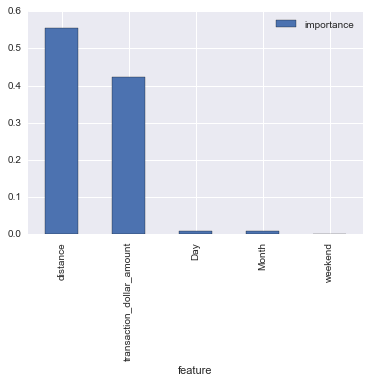

In [39]:
importances = pd.DataFrame({'feature':Xtrain.columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
print (importances)
importances.plot.bar()

In [40]:
print (results_train[0][0]+results_train[1][1])/len(train)

0.98566284613


In [41]:
results_test = pd.crosstab(rf.predict(Xtest),Ytest)
print results_test

Possible_fraud      0     1
row_0                      
0               65402  6626
1                2846  9633


In [42]:
print (results_test[0][0]+results_test[1][1])/len(test)

0.887914610624


## Unisupervised algorithm

Unisupervised algorithm can be done on credit card either as whole or individually 

## Clustering on either credit_card data 

In [43]:
df= trans.pivot_table(index=['credit_card'],columns='weekend',values='transaction_dollar_amount',aggfunc=[np.sum ,np.count_nonzero]).reset_index()

In [44]:
df.head()


credit_card       sum           count_nonzero       
weekend                           0         1             0      1
0        1003715054175576  21193.26   7646.58         192.0   69.0
1        1013870087888817  26245.28  10569.60         249.0   92.0
2        1023820165155391  45127.95  15924.61         391.0  134.0
3        1073931538936472   4772.38   2633.89          34.0   13.0
4        1077622576192810   1025.18    765.55           7.0    6.0

In [45]:
df.columns=['credit_card','Weekend_purchase','Non_weekend_purchase','Weekend_count','Non_Weekend_count']

In [46]:
from scipy import stats

In [47]:
trans_most_freq=pd.DataFrame({'Most_frequent': trans_union.groupby(['credit_card'])['Day'].agg(lambda x: stats.mode(x)[0][0])}).reset_index()

In [48]:
df  = pd.merge(df,trans_amount,on='credit_card')
df  = pd.merge(df,trans_distance,on='credit_card')
df = pd.merge(df,trans_most_freq,on='credit_card')
df=pd.merge(df,credit_card,on='credit_card')


In [49]:
df = df.drop(['zipcode','state'],axis=1)

In [50]:
df=df.fillna(0)

In [51]:
df['city']=df['city'].astype('category')
df['city']=df['city'].cat.codes

In [52]:
df.head()

,credit_card,Weekend_purchase,Non_weekend_purchase,Weekend_count,Non_Weekend_count,90Percentile_amount,Mean_ammount,90Percentile_distance,Mean_distance,Most_frequent,city,credit_card_limit
0,1003715054175576,21193.26,7646.58,192.0,69.0,158.520,110.497471,8.790,254.174100,5,45,20000
1,1013870087888817,26245.28,10569.60,249.0,92.0,165.250,107.961525,8.700,139.557449,5,109,15000
2,1023820165155391,45127.95,15924.61,391.0,134.0,158.812,116.290590,8.746,48.148229,5,17,28000
3,1073931538936472,4772.38,2633.89,34.0,13.0,216.650,157.580213,8.644,164.533617,5,25,10000
4,1077622576192810,1025.18,765.55,7.0,6.0,175.080,137.748462,8.644,6.341538,0,45,10000


In [53]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from ggplot import *

In [54]:
feature_col= df.columns[1:-1]
print (feature_col)

Index([u'Weekend_purchase', u'Non_weekend_purchase', u'Weekend_count',
       u'Non_Weekend_count', u'90Percentile_amount', u'Mean_ammount',
       u'90Percentile_distance', u'Mean_distance', u'Most_frequent', u'city'],
      dtype='object')


In [55]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

X=df[feature_col]

range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]

lst=defaultdict(float)

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print ("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    lst[n_clusters]=silhouette_avg

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)



Automatically created module for IPython interactive environment
('For n_clusters =', 2, 'The average silhouette_score is :', 0.60270664371077154)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.55901659616512311)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.54402846716125575)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.51895972731389661)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.491814444514448)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.49116867305039436)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.48867710457215086)
('For n_clusters =', 9, 'The average silhouette_score is :', 0.48320104764792809)
('For n_clusters =', 10, 'The average silhouette_score is :', 0.46580495821765622)


### Scree plot (Elbow plot can be used to identify the no of optimized cluster 

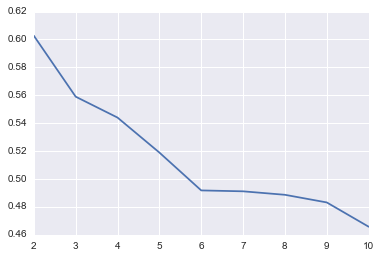

In [56]:
print (plt.plot(lst.keys(),lst.values()))

In [57]:
cluster = KMeans(n_clusters=6)

df['cluster'] = cluster.fit_predict(df[df.columns[1:]])
df.cluster.value_counts()

1    309
4    258
0    173
5    128
3     52
2     21
Name: cluster, dtype: int64

In [58]:
pca = PCA(n_components=2)
df['x'] = pca.fit_transform(df[feature_col])[:,0]
df['y'] = pca.fit_transform(df[feature_col])[:,1]
#df = df.reset_index()

customer_clusters = df[['credit_card', 'cluster', 'x', 'y']]
customer_clusters.head()

,credit_card,cluster,x,y
0,1003715054175576,0,-2574.537503,-498.331806
1,1013870087888817,0,-8343.700431,388.428825
2,1023820165155391,3,-27881.851084,-1485.658037
3,1073931538936472,1,14545.798496,800.282931
4,1077622576192810,1,18715.984877,421.278426


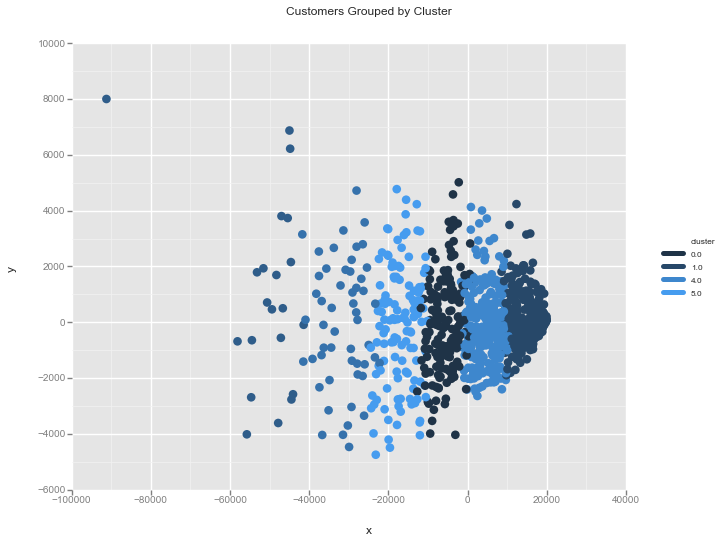

<ggplot: (19850598)>


In [59]:
print (ggplot(customer_clusters, aes(x='x', y='y', color='cluster')) + \
    geom_point(size=75) + \
    ggtitle("Customers Grouped by Cluster"))

In [60]:
final_results = pd.merge(df,credit_card[['city','credit_card']],on='credit_card')

## Clustering on the individual transaction 

In [61]:
def function (df,n_clusters):
    
    if len(df) > 2:   
        cluster = KMeans(n_clusters=n_clusters)
        df['cluster'] = cluster.fit_predict(df[df.columns[1:]])
        #print df.cluster.value_counts()
        feature_col= df.columns[1:-1]

        a = dict(df.cluster.value_counts())
        items =a.items()
        items.sort(key=lambda item: (item[1], item[0]))
        sorted_keys = [ item[0] for item in items ][0:n_clusters-1]


        pca = PCA(n_components=2)
        df['x'] = pca.fit_transform(df[feature_col])[:,0]
        df['y'] = pca.fit_transform(df[feature_col])[:,1]

        customer_clusters = df[['credit_card', 'cluster', 'x', 'y']]
        customer_clusters.head()
    #     print \
    #         ggplot(customer_clusters, aes(x='x', y='y', color='cluster'))\
    #         +geom_point(size=75) + ggtitle("Customers Grouped by Cluster") 

        final_results = pd.merge(df,credit_card[['city','credit_card']],on='credit_card')
        final_results.columns
        first = True
        for cluster in sorted_keys:
            if first:
                final_df = final_results [(final_results['cluster']==cluster)]
                first = False
            else:
                final_df = final_df.union(final_results[(final_results['cluster']==cluster)])
                
        return final_df

    else:
        
        return None

In [62]:
first = True
for card in credit_card['credit_card']:
#    print card
    cluster=2
    if first:
        df2 = function(final_df[final_df['credit_card']==card],2) 
                                ## 2 cluster since one for normal activities and one for any abnormal activities
        first=False
    else:
        
        df2 = df2.append(function(final_df[final_df['credit_card']==card],2)) 

C:\Users\vadivel.datchi\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\vadivel.datchi\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\vadivel.datchi\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [63]:
final_results2 = df2.groupby('credit_card')['transaction_dollar_amount']

final_results = pd.DataFrame({'count':final_results2.count(),'trans_amount':final_results2.sum()}).reset_index()


In [64]:
len(final_results)

936

In [65]:
sorted_df = final_results.sort_values(['trans_amount','count'],ascending=False).set_index('credit_card')

Axes(0.125,0.125;0.775x0.775)


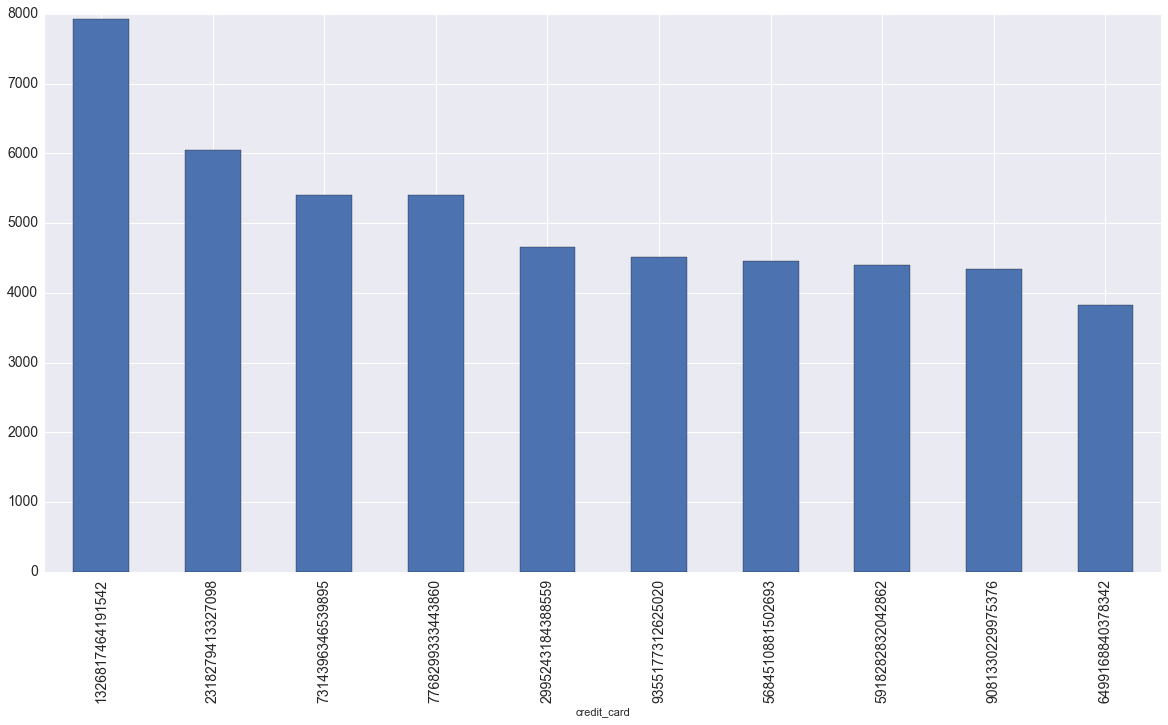

In [66]:
print (sorted_df['trans_amount'][0:10].plot.bar(figsize=[20,10],fontsize=14))